# This notebook is to evaluate embedding derived from networks

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import networkx as nx
from scipy.stats import ttest_ind
from sklearn.metrics import normalized_mutual_info_score as nmi
from functions.subset_network import subset_network
from functions.eda_functions import *
from functions.network_embedding import network_embedding
from functions.process_phenotype import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

# Network community evaluation

## Evaluation 1: correlation between phenotypes and network modules

In [3]:
meta = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\kapoor2019_coga.inia.detailed.pheno.04.12.17.csv')

In [4]:
expression = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\kapoor2019_batch.age.rin.sex.pm.alc.corrected.coga.inia.expression.txt', sep = '\t')

In [5]:
tom_df = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\Kapoor_TOM.csv', index_col = 0) 

In [6]:
expression = expression[expression.id.isin(tom_df.index)]

In [7]:
expression_t = expression.T
expression_t.columns = expression_t.iloc[0,:]
expression_t.drop('id', inplace=True)

In [180]:
expression_meta = pd.merge(expression_t, meta, left_index = True, right_on = 'IID')

In [182]:
expression_meta.to_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\expression_meta.csv', index = 0)

In [5]:
expression_meta = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\expression_meta.csv', low_memory = False)

In [184]:
expression_meta.head()

,ENSG00000227232,ENSG00000237683,ENSG00000241860,ENSG00000228463,ENSG00000225972,ENSG00000225630,ENSG00000237973,ENSG00000229344,ENSG00000248527,ENSG00000198744,...,Agonal_phase,Liver_class,Smoking_frequency,Pack_yrs_1_pktperday_1_yr),AUDIT,alcohol_intake_gmsperday,Total_drinking_yrs,Depression,Anxiety,SR
0,3.133118,3.823457,1.022690,4.174664,4.721111,6.249569,10.326613,5.613722,7.627960,6.452445,...,Rapid,Steatosis,99 - Not reported,NaN,186.0,266.0,23.0,Yes,No,1
1,2.389945,1.997970,0.368830,3.233721,5.096691,7.036703,11.125171,5.548298,7.972209,6.557081,...,Rapid,Normal,99 - Not reported,NaN,NaN,NaN,NaN,No,No,2
2,1.877375,2.878354,0.028265,3.250095,4.613348,6.347241,10.051990,5.206124,7.612012,6.188654,...,Rapid,Normal,01 - Everyday/7days per week,42.0,42.0,102.0,27.0,Yes,No,3
3,2.657129,1.632495,0.247083,4.155158,5.912895,7.480004,11.234187,6.384119,8.501137,6.789110,...,Intermediate,Steatosis,99 - Not reported,NaN,0.0,0.0,NaN,No,No,4
4,3.186562,3.185500,1.100501,2.999840,5.616984,7.564768,10.804071,6.327458,8.428120,7.109489,...,Rapid,Normal,01 - Everyday/7days per week,38.0,56.0,136.0,31.0,Yes,No,5


## Evaluation 1a: Find variable genes between phenotype groups. Use Alc_status as the control since it was used to calculate DE.

#### Use t-test to compare between the alcoholic group and the control group. It only works when they're two groups. For multiple groups or groups with continuous values (such as AUDIT), we need other methods to get those "variable genes". I haven't figured out the method yet. 

In [15]:
variable_genes = []
for col in expression_meta.columns[:19911]:
    ttest = ttest_ind(expression_meta[expression_meta.Alc_status == 'Alcoholic'][col], expression_meta[expression_meta.Alc_status == 'Control'][col])
    if ttest[1] < 0.5:
        variable_genes.append(col)

In [17]:
# collect up genes if the mean is higher in alcoholic than control
up_genes = []
for gene in variable_genes:
    alc = expression_meta[expression_meta.Alc_status == 'Alcoholic'][gene]
    control = expression_meta[expression_meta.Alc_status == 'Control'][gene]
    if np.mean(alc) > np.mean(control):
        up_genes.append(gene)

In [18]:
down_genes = []
for gene in variable_genes:
    alc = expression_meta[expression_meta.Alc_status == 'Alcoholic'][gene]
    control = expression_meta[expression_meta.Alc_status == 'Control'][gene]
    if np.mean(alc) < np.mean(control):
        down_genes.append(gene)

In [12]:
deseq = pd.read_excel(r'G:\Shared drives\NIAAA_ASSIST\Data\deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')

In [6]:
community_df = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\network_louvain_default.csv') # default is the one ran with louvain and got 10 communities, not 26 in the paper

### Use NMI to determine how well the network community labels correlate with the alcohol phenotypes. The idea is up_genes belong to 1 cluster and down_genes belong to another cluster. 

In [13]:
def nmi_features_genes_n_community(gene_sets, community = community_df):
    community_id = []
    gene_set_id = []
    for i, g_set in enumerate(gene_sets):
        community_id += community_df[community_df['id'].isin(g_set)]['louvain_label'].tolist()
        gene_set_id += [i]*len(g_set)
    return nmi(community_id, gene_set_id)

In [33]:
# up_genes and down_genes each as a cluster 
nmi_both = nmi_features_genes_n_community([up_genes, down_genes])

In [34]:
# up_genes as a cluster only
nmi_up = nmi_features_genes_n_community([up_genes])

In [35]:
# down_genes as a cluster only
nmi_down = nmi_features_genes_n_community([down_genes])

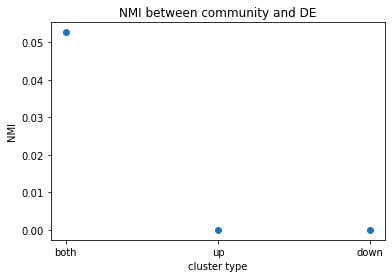

In [38]:
plt.scatter(['both','up', 'down'], [nmi_both, nmi_up, nmi_down])
plt.xlabel('cluster type')
plt.ylabel('NMI')
plt.title('NMI between community and DE');

## Evaluation 1b.1: Measure percentage of genes in a module that are significantly variable for specific traits

### What percentage of genes are significantly different between AUDIT groups as determined by ANOVA?

In [186]:
# get the expression of the patients grouped by AUDIT score with AUDIT = nan removed
audit_subset = get_expression_by_audit()

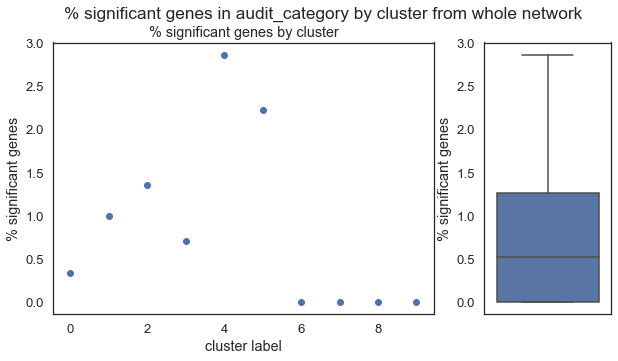

In [363]:
# correlation between audit phenotype and communities in the network 
plot_sig_perc(audit_subset, community_df, 'louvain_label', 'audit_category', 'whole network')

## Evaluation 1b.2: Measure correlation between alcohol phenotypes and genes in a module

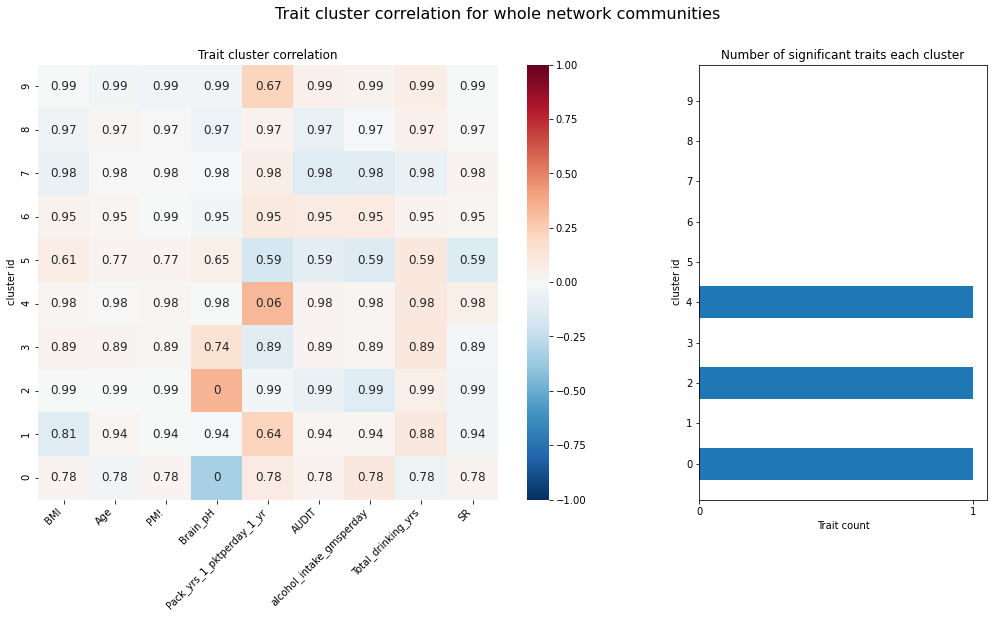

In [276]:
cluster_phenotype_corr(expression_meta, community_df, 'louvain_label', 'whole network communities')

# Embedding evaluation

## Evaluation 1: embedding cluster comparison

In [ ]:
# Different subnetwork will create different embedding. How will the clusters from these different embeddings compare?

In [ ]:
tom_df = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\Kapoor_TOM.csv', index_col = 0) 

In [140]:
subset_G = []
subset_df = []
for weight in [0.218, 0.24, 0.278]:
    subset, G = subset_network(tom_df, weight, 0.98)
    subset_df.append(subset)
    subset_G.append(G)
    emb_df = network_embedding(G, 16, 100, 10, 'C:/Users/bbche/Documents/GitRepos/assist/data', weight)

Number of edges left: 10100.0


Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


embedding data saved
Number of edges left: 4967.0


Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.06it/s]


embedding data saved
Number of edges left: 1092.0


Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.00it/s]


embedding data saved


### Evaluation 1a.1: compare embedding from subnetworks by comparing k mean clusters with jaccard

In [10]:
os.chdir(r'C:\Users\bbche\Documents\GitRepos\assist\data')
subset_kmeans = []
for file in ['embedded_len16_walk100_0.218.csv', 'embedded_len16_walk100_0.24.csv', 'embedded_len16_walk100_0.278.csv']:
    emb = pd.read_csv(file, index_col = 0)
    subset_kmeans.append(run_kmeans(emb, 10))

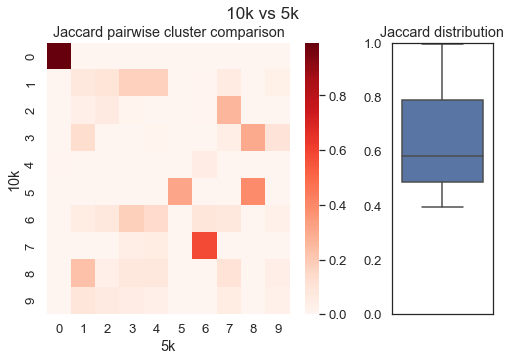

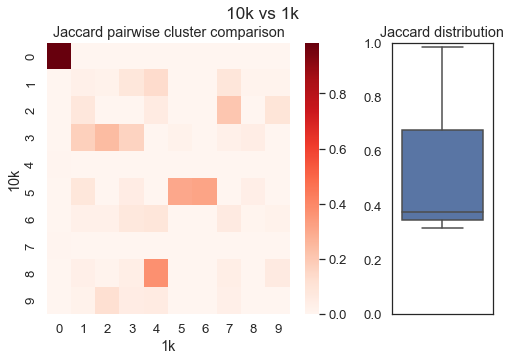

In [161]:
cluster_jaccard(subset_kmeans[0], subset_kmeans[1], 'kmean_label', ['10k','5k'], top = 3)
cluster_jaccard(subset_kmeans[0], subset_kmeans[2], 'kmean_label', ['10k','1k'], top = 3)

### Evaluation 1a.2: compare embedding from subnetworks by comparing k mean clusters with NMI

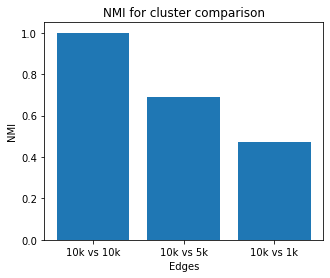

In [20]:
plot_cluster_nmi_comparison(subset_kmeans[0], subset_kmeans, 
                            'kmean_label', ['10k vs 10k', '10k vs 5k', '10k vs 1k'])

### Evaluation 1b.1: Measure percentage of genes in each cluster that are significantly variable for specific traits

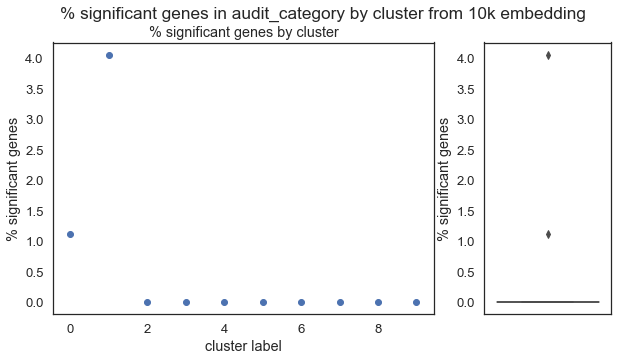

In [369]:
# Correlation between 10k embedding and AUDIT phenotype
plot_sig_perc(audit_subset, subset_kmeans[0], 'kmean_label', 'audit_category', '10k embedding')

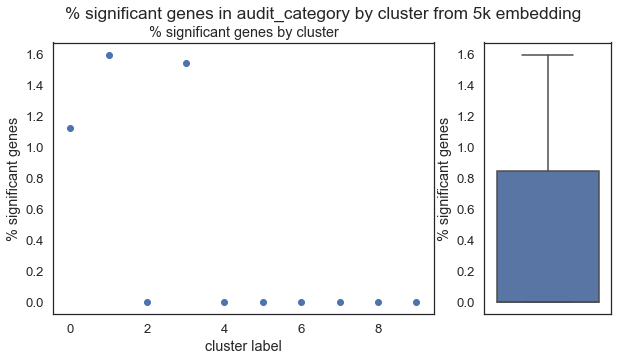

In [228]:
plot_sig_perc(audit_subset, subset_kmeans[1], 'kmean_label', 'audit_category', '5k embedding')

### Evaluation 1b.2: Measure percentage of genes in each module that are significantly variable for specific traits

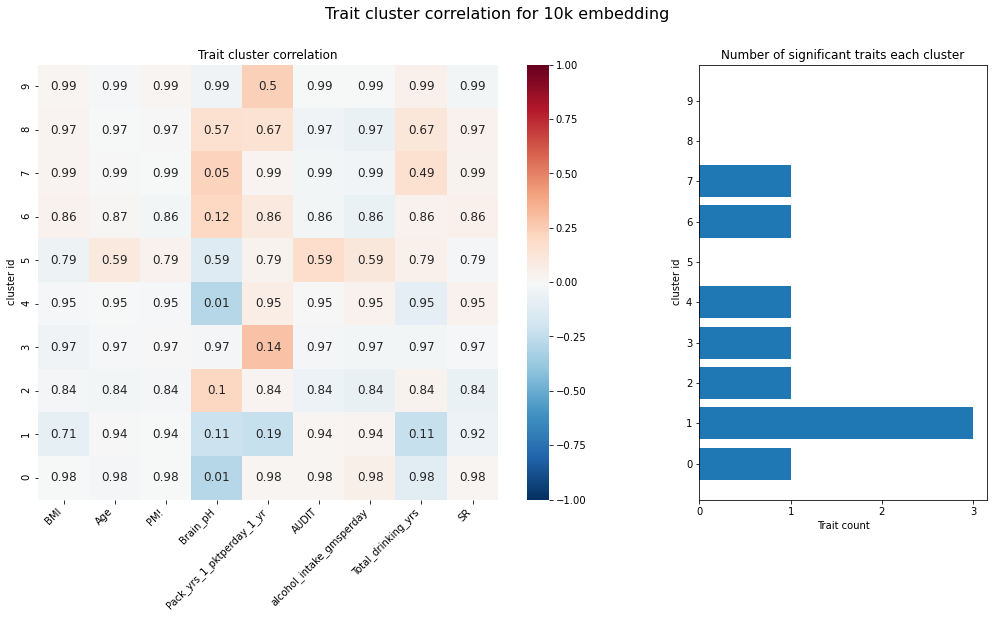

In [274]:
cluster_phenotype_corr(expression_meta, subset_kmeans[0], 'kmean_label', '10k embedding')

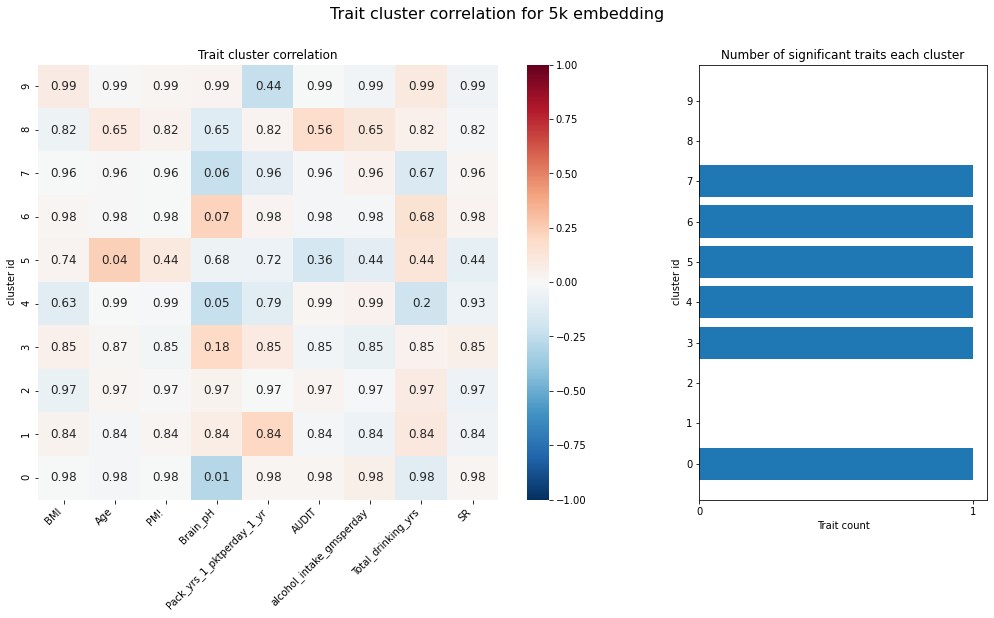

In [273]:
cluster_phenotype_corr(expression_meta, subset_kmeans[1], 'kmean_label', '5k embedding')

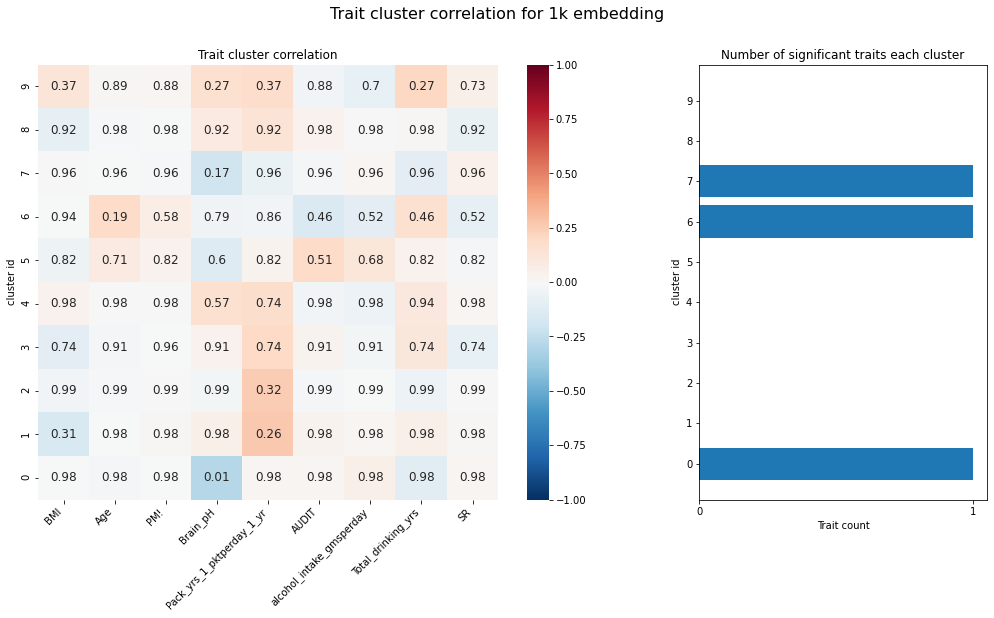

In [275]:
cluster_phenotype_corr(expression_meta, subset_kmeans[2], 'kmean_label', '1k embedding')